# Daily pattern of the input, deseasonalization

*This is a sub-notebook of the series on Input modeling*

Objective: model the daily pattern (mean and variance) of the input in order to **deseasonalize** it. That is make the times series quite stationnary, centered and have a unit variance.

* $P_{load}$: the power demand of the house
* $P_{sun}$: the available solar power

These two inputs could be modeled separately, but since this model will be used by a Dynamic Programming based energy management, we are limited by the curse of dimensionality. So we will model the *net load*:

$$P_{nl}= P_{load} - P_{sun}$$


Here we focus on modeling the daily trend (mean) and scale (std):

$$ P_{nl}(k) = \mu(h_k) + s(h_k).X(k) $$

where:

* $h_k$ is an external regressor: the hour of the day ($0 \leq h < 24$)
* $X(k)$ is stationnary process, centered with unit variance.
* function $h \mapsto \mu(h)$ and $h \mapsto s(h)$ are the mean and scale daily pattern functions, **to be determined here**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Import solarhome utility module

In [2]:
from pathlib import Path
p_utils = Path('../utils')
assert(p_utils.exists())

import sys
sys.path.append(str(p_utils))

import benchutils
from benchutils import load_data, load_results

## Load testcase data — training set


In [3]:
params, data = load_data(subset='train', keep_date=True)

Parameters:

In [5]:
dt = 0.5 # hours
P_pvp = params['P_pvp']
print('P_pvp: {:.1f} kW'.format(P_pvp))

P_pvp: 4.0 kW


Time series

In [6]:
P_load = data.P_load_sp
P_sun = data.P_sun_1k*P_pvp;

Compute "net load": $P_{nl}= P_{load} - P_{sun}$

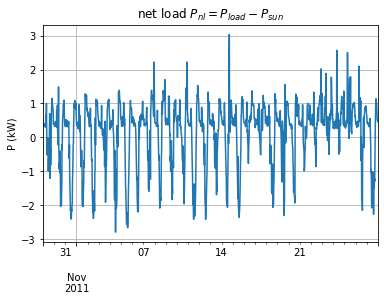

In [7]:
P_nl = P_load - P_sun
ax = P_nl.plot()
ax.set(ylabel='P (kW)', title="net load $P_{nl}= P_{load} - P_{sun}$")
plt.grid()

## Daily pattern overview 

### Data folded by hod

useful for spaghetti plot and GMM modeling

In [88]:
P_fold = P_nl.values.reshape((-1,48))
P_fold.shape

(30, 48)

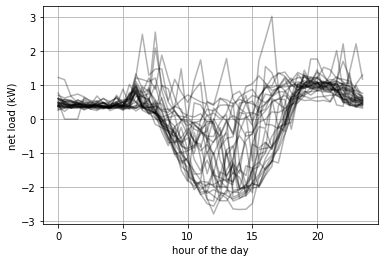

In [89]:
plt.plot(np.arange(48)/2, P_fold.T, 'k-', alpha=0.3);
plt.xlabel('hour of the day')
plt.ylabel('net load (kW)')
plt.grid();

### Groupby hod

nb: some code here pasted from "Ausgrid Solar Home/Customer exploration" notebook.

In [8]:
def hod(tstamp):
    'hour of the day (fractional))'
    return tstamp.hour + tstamp.minute/60

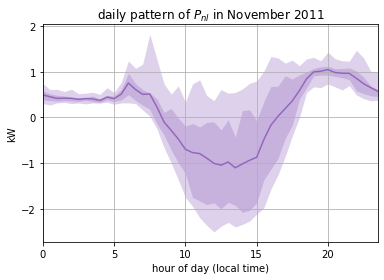

In [9]:
c = 'tab:purple'
P_byhod = P_nl.groupby(hod)
P_dm = P_byhod.mean()

ax = P_dm.plot(c=c)
ax.fill_between(P_dm.index, P_byhod.quantile(.05), P_byhod.quantile(.95),
                alpha=0.3, color=c, lw=0)
ax.fill_between(P_dm.index, P_byhod.quantile(.25), P_byhod.quantile(.75),
                alpha=0.3, color=c, lw=0)
ax.set(
    title='daily pattern of $P_{nl}$ in November 2011',
    ylabel='kW',
    xlabel='hour of day (local time)'
)
ax.grid()

plt.savefig('net-load_daily_pattern_2011-11.png',
            dpi=200, bbox_inches='tight')

In [10]:
quantiles = np.linspace(0.05, 0.95, 19)
quantiles

def daily_pattern(ts):
    '''compute statistics for each hour of the day (min, max, mean and quantiles)
    of the time series `ts`
    
    returns DataFrame with columns 'mean','min', 'qXX'..., 'max'
    and rows being the hours of the day between 0. and 24.
    '''
    dstats = pd.DataFrame({
        'q{:02.0f}'.format(q*100) : ts.groupby(by=hod).quantile(q)
        for q in quantiles
    })
    dstats.insert(0, 'min',  ts.groupby(by=hod).min())
    dstats.insert(0, 'mean', ts.groupby(by=hod).mean())
    dstats['max'] = ts.groupby(by=hod).max()
    return dstats

In [11]:
def plot_daily_pattern(dstats, title):
    fig, ax = plt.subplots(1,1)
    
    q_names = [c for c in dstats.columns if c.startswith('q')]
    
    dstats[q_names].plot(ax=ax, color='k', lw=0.5, alpha=0.7)    
    dstats['q50'].plot(ax=ax, color='k')
    
    ax.fill_between(P_dm.index, dstats['min'], dstats['max'],
                alpha=0.2, color='tab:purple', lw=0)
    dstats['mean'].plot(ax=ax, color='tab:purple', lw=6, alpha=0.7)
    plt.legend(ax.lines[-3:], ['q 5, 10, ...95%', 'med', 'mean']);
    
    ax.set(
        xlabel='hour of the day',
        ylabel='Power (kW)',
        title=title)
    fig.tight_layout()
    return fig, ax

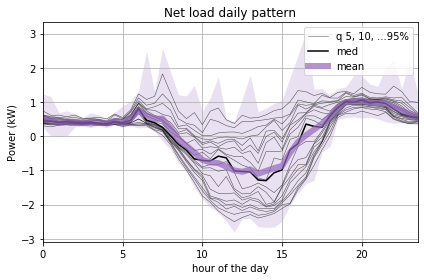

In [12]:
fig, ax = plot_daily_pattern(daily_pattern(P_nl),
    title='Net load daily pattern')
ax.grid()
fig.savefig('net-load_daily_pattern_q_2011-11.png',
            dpi=200, bbox_inches='tight')

#### Histogram for time windows

In [13]:
def dper(tstamp):
    'periods of the day'
    h = tstamp.hour + tstamp.minute/60
    if h<=5 or h>23:
        return "1 night"
    if h<=8:
        return "2 dawn"
    if h<= 11:
        return "3 morn"
    if h<= 14:
        return "4 mid"
    if h<= 18:
        return "5 aftn"
    if h<= 23:
        return "6 even"
    return "-1"

/home/pierre/Programmes/miniconda3.7/lib/python3.7/site-packages/pandas/plotting/_core.py:2491: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ylabelsize=ylabelsize, yrot=yrot, **kwds)


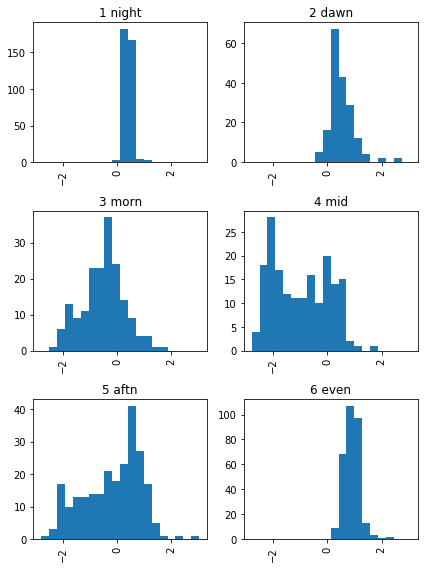

In [14]:
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111)
ax = P_nl.hist(bins=20, by=dper,
               ax = ax,
               range=(P_nl.min(), P_nl.max()),
               #cumulative=True, density=True
              );
fig.tight_layout();

Observation: there is some **bimodality** when the sun is shining

*histogram for each hod to be continued*. Using a widget?

## Daily pattern modeling with wavelets

tools: regression, wavelets (see [Input_wavelet_analysis.ipynb](Input_wavelet_analysis.ipynb) for more study of wavelets)

In [15]:
from sklearn import linear_model

In [16]:
import pywt

In [17]:
wavelet='db2'
mode = 'periodization'

wcoeffs = pywt.wavedec(P_dm, wavelet, mode=mode)
level = len(wcoeffs) -1

###  1) Wavelet experiment: progressive reconstruction of daily pattern


Reconstruction with selected coefficients

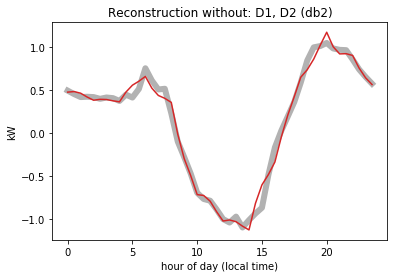

In [18]:
wcoeffs_filt = [c.copy() for c in wcoeffs]
select = np.ones(len(wcoeffs))
rem_coeff = []
select[-1] = 0; rem_coeff.append('D1')
select[-2] = 0; rem_coeff.append('D2')
#select[-3] = 0 ; rem_coeff.append('D3')
#select[-4] = 0 ; rem_coeff.append('D4')
#select[-5] = 0 ; rem_coeff.append('D5')
#select[0] = 0 ; rem_coeff.append('A5')

for k, s in enumerate(select):
    wcoeffs_filt[k] *= s

plt.plot(P_dm, color='k', lw=6, alpha=0.3)
plt.plot(P_dm.index, pywt.waverec(wcoeffs_filt, wavelet, mode), color='tab:red');
ax = plt.gca()
ax.set(
    title='Reconstruction without: {} ({})'.format(', '.join(rem_coeff), wavelet),
    xlabel='hour of day (local time)',
    ylabel='kW'
);

Reconstruction with cumulated details

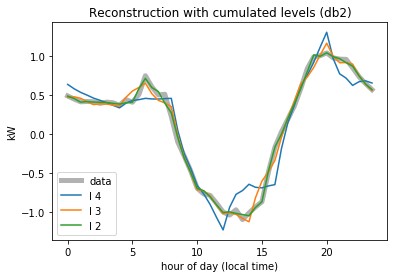

In [19]:
def recons_level(wcoeffs, l):
    '''reconstruct signal down to level `l`'''
    wcoeffs_r = [c.copy() for c in wcoeffs]
    select = np.ones(len(wcoeffs))
    assert l <= level
    if l>=2:
        select[-l+1:] = 0
    elif l==1:
        pass

    for k, s in enumerate(select):
        wcoeffs_r[k] *= s
        
    return pywt.waverec(wcoeffs_r, wavelet, mode)

plt.plot(P_dm, color='k', lw=5, alpha=0.3, label='data')
plt.plot(P_dm.index, recons_level(wcoeffs, 4), label='l 4')
plt.plot(P_dm.index, recons_level(wcoeffs, 3), label='l 3')
plt.plot(P_dm.index, recons_level(wcoeffs, 2), label='l 2')
plt.legend()

ax = plt.gca()
ax.set(
    title='Reconstruction with cumulated levels ({})'.format(wavelet),
    xlabel='hour of day (local time)',
    ylabel='kW'
);

### 2) Mean pattern with regression

idea: use a penalty (L1, L2) to smooth the result, in order to be better immune to data variability

#### Wavelet-based regression basis

*basis built in [Input_wavelet_analysis.ipynb](Input_wavelet_analysis.ipynb) and saved to CSV file*

Issue noticed in July 2019: the first three base vectors are colinear (A4_1 + A4_2 + A4_3 = 0).
Indeed, there are periodic functions (T0=48) with a 120° phase shift.

Conclusion: one should be removed

In [47]:
wavelet='db2'

basis = np.loadtxt('basis_db2_3-3-6-12-24.csv', skiprows=1, delimiter=',')
basis = basis[:,1:]
basis.shape

(48, 47)

size of the "blocks" in the basis

In [48]:
w_lens = [2,3,6,12,24]

In [49]:
with open('basis_db2_3-3-6-12-24.csv') as f:
    line = f.readline().strip()

b_names = line.split(',')
b_names = b_names[1:]
b_names[:7]

['A4_2', 'A4_3', 'D4_1', 'D4_2', 'D4_3', 'D3_1', 'D3_2']

In [50]:
ndays = len(P_nl)/48
assert ndays == round(ndays)
ndays = int(ndays)

Xdb2 = np.tile(basis, (ndays, 1))
Xdb2.shape

(1440, 47)

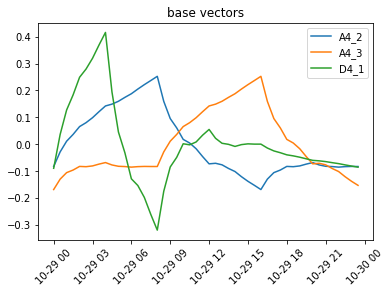

In [51]:
for i in [0,1,2]:
    plt.plot(P_nl.index[:48], Xdb2[:48,i], label=f'{b_names[i]}')

ax = plt.gca()
ax.xaxis.set_tick_params(rotation=45)
ax.legend()
plt.title('base vectors');

#### Classical linear regression (not penalized)

used as a reference, to check things work

In [53]:
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(Xdb2, P_nl)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
reg.intercept_

0.145309935897436

In [55]:
np.cumsum(w_lens)

array([ 2,  5, 11, 23, 47])

In [56]:
reg.coef_[0:4]

array([-1.47597615, -5.34282756, -0.35410967, -1.44536104])

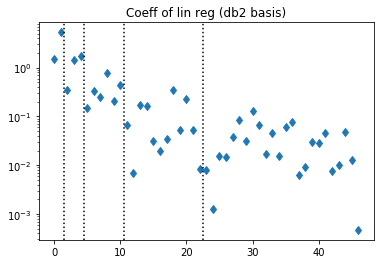

In [57]:
plt.semilogy(np.abs(reg.coef_), 'd')
for x in np.cumsum(w_lens[:-1]):
    plt.axvline(x-0.5, c='k', ls=':')
plt.title('Coeff of lin reg (db2 basis)');

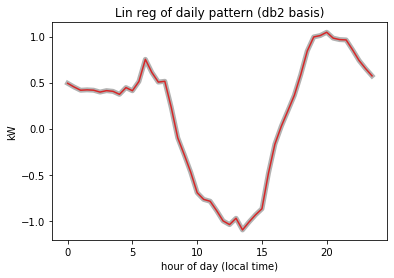

In [58]:
plt.plot(P_dm, color='k', lw=5, alpha=0.3)
plt.plot(P_dm.index, reg.predict(Xdb2[:48,:]), color='tab:red')

ax = plt.gca()
ax.set(
    title='Lin reg of daily pattern ({} basis)'.format(wavelet),
    xlabel='hour of day (local time)',
    ylabel='kW'
);

#### Ridge regression

In [59]:
alphaR = 10
regR = linear_model.Ridge(alpha = alphaR)
regR.fit(Xdb2, P_nl)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

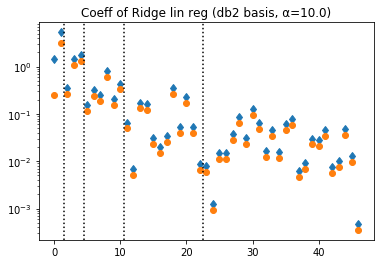

In [60]:
plt.semilogy(np.abs(reg.coef_), 'd')
plt.semilogy(np.abs(regR.coef_), 'o')

for x in np.cumsum(w_lens[:-1]):
    plt.axvline(x-0.5, c='k', ls=':')
plt.title('Coeff of Ridge lin reg (db2 basis, α=%.1f)' % alphaR);

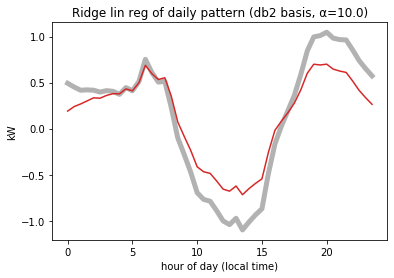

In [61]:
plt.plot(P_dm, color='k', lw=5, alpha=0.3)
plt.plot(P_dm.index, regR.predict(Xdb2[:48,:]), color='tab:red')

ax = plt.gca()
ax.set(
    title='Ridge lin reg of daily pattern ({:} basis, α={:.1f})'.format(wavelet, alphaR),
    xlabel='hour of day (local time)',
    ylabel='kW'
);

**Problem** all coefficients are similarly reduced, the pattern is just scaled down. High frequencies are not specifically targeted. This is useless as is.

* Maybe penalize more the high frequencies by reducing the amplitude of basis vector ?
* quick googling: it seems some Bayesian approach give a prior on the distribution of coefficients...

#### Lasso

In [62]:
alphaL = 2e-3
regL = linear_model.Lasso(alpha = alphaL)
regL.fit(Xdb2, P_nl)

Lasso(alpha=0.002, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [63]:
sum(np.abs(reg.coef_)>0), sum(np.abs(regL.coef_)>0)

(47, 16)

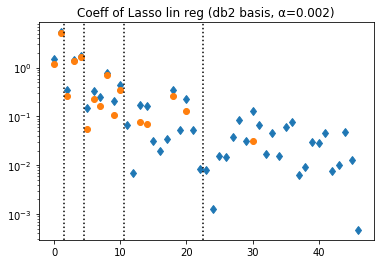

In [64]:
plt.semilogy(np.abs(reg.coef_), 'd')
plt.semilogy(np.abs(regL.coef_), 'o')

for x in np.cumsum(w_lens[:-1]):
    plt.axvline(x-0.5, c='k', ls=':')
plt.title('Coeff of Lasso lin reg (db2 basis, α=%g)' % alphaL);

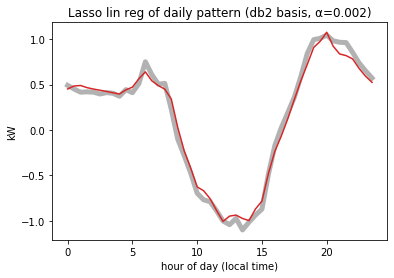

In [65]:
plt.plot(P_dm, color='k', lw=5, alpha=0.3)
plt.plot(P_dm.index, regL.predict(Xdb2[:48,:]), color='tab:red')

ax = plt.gca()
ax.set(
    title='Lasso lin reg of daily pattern ({:} basis, α={:g})'.format(wavelet, alphaL),
    xlabel='hour of day (local time)',
    ylabel='kW'
);

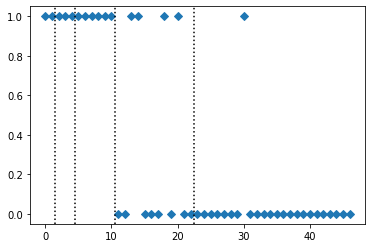

In [66]:
nnz = np.abs(regL.coef_)>0
plt.plot(nnz, 'D');
for x in np.cumsum(w_lens[:-1]):
    plt.axvline(x-0.5, c='k', ls=':')

In [67]:
X_sp = Xdb2 * nnz

In [68]:
reg_sp = linear_model.LinearRegression()
reg_sp.fit(X_sp, P_nl)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

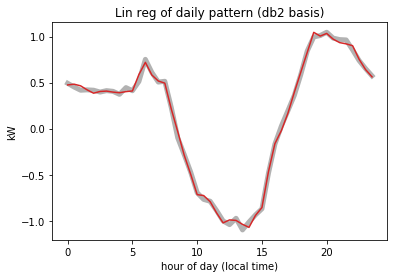

In [69]:
plt.plot(P_dm, color='k', lw=5, alpha=0.3)
plt.plot(P_dm.index, reg_sp.predict(X_sp[:48,:]), color='tab:red')

ax = plt.gca()
ax.set(
    title='Lin reg of daily pattern ({} basis)'.format(wavelet),
    xlabel='hour of day (local time)',
    ylabel='kW'
);

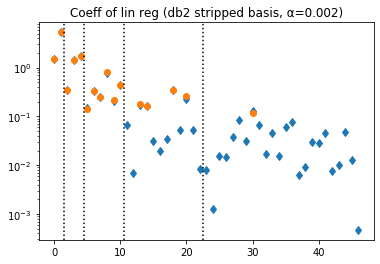

In [70]:
plt.semilogy(np.abs(reg.coef_), 'd')
plt.semilogy(np.abs(reg_sp.coef_*nnz), 'o')

for x in np.cumsum(w_lens[:-1]):
    plt.axvline(x-0.5, c='k', ls=':')
plt.title('Coeff of lin reg (db2 stripped basis, α=%g)' % alphaL);

Observation: once the basis is stripped, the result of the regression is almost equal to original coeffs. All this work for just some coefficient thresholding?!

maybe direct thresholding of wavelet coefficients is better than regression ?

* http://pywavelets.readthedocs.io/en/latest/ref/thresholding-functions.html
* http://pywavelets.readthedocs.io/en/latest/ref/dwt-coefficient-handling.html#pywt.coeffs_to_array

idea: use cross-validation to compute WT for each N-1 sample, then compare the coefficients and take only the one which don't move too much? (small mean/std ratio ?)

### 3) Mean pattern smoothing with wavelet threholding

#### Cross validation mean patterns

Mean pattern of leave-one-out samples. Since there are only 31 days, all cases can be computed. Because of potential persistence, let's remove 3 days in a block.

In [71]:
# day index, (more robust against a potential change of year than dayofyear)
day = (P_nl.index - P_nl.index[0]).days
day

Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            ...
            29, 29, 29, 29, 29, 29, 29, 29, 29, 29],
           dtype='int64', length=1440)

3.0

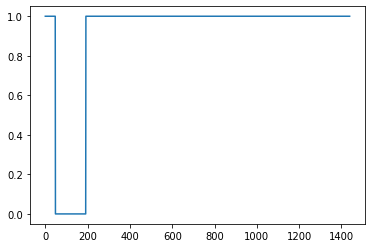

In [72]:
i = 1
n = 3
# boolean vector of the days to exclude:
a = (day >= i) & (day <= i+n-1)
plt.plot(~a)
a.sum()/2/24 # == n

In [73]:
def day_block_exclude(x, i, n):
    'exclude the i-th block of n consecutive days from Series x'
    day = (x.index - x.index[0]).days
    assert i>=0
    assert max(day) >= i+n-1, 'i should be <= n_days - n'
    a = (day >= i) & (day <= i+n-1)
    return x[~a]

In [74]:
P_nl.index[0], P_nl.index[-1]

(Timestamp('2011-10-29 00:00:00'), Timestamp('2011-11-27 23:30:00'))

In [75]:
ndays =  (P_nl.index[-1] - P_nl.index[0]).days + 1
ndays

30

In [76]:
day_block_exclude(P_nl, 0, n=3).head(3)

2011-11-01 00:00:00    0.492
2011-11-01 00:30:00    0.344
2011-11-01 01:00:00    0.396
dtype: float64

In [77]:
len(day_block_exclude(P_nl, 0, n=3))/2/24

27.0

In [78]:
day_block_exclude(P_nl, ndays-3, n=3).tail(3)

2011-11-24 22:30:00    1.360
2011-11-24 23:00:00    0.364
2011-11-24 23:30:00    0.326
dtype: float64

(14, 48)

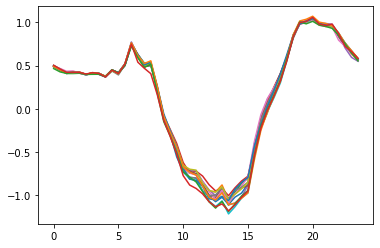

In [79]:
def dm_cv(x, n):
    'daily mean leave-one-out samples'
    
    x_dm_cv = []
    for i in range(0, ndays-n, n):
        x_dm_cv.append(day_block_exclude(x, i, n).groupby(hod).mean())
    # stack in a 2D array (n_samp, n_hod)
    return np.array(x_dm_cv)

P_dm_cv = dm_cv(P_nl, 2)

plt.plot(P_dm.index, P_dm_cv.T, alpha=1);
P_dm_cv.shape

(9, 48)

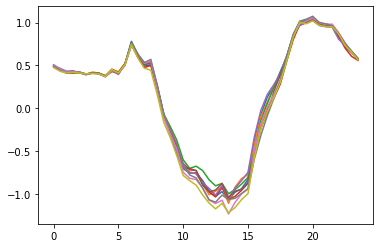

In [80]:
P_dm_cv = dm_cv(P_nl, 3)

plt.plot(P_dm.index, P_dm_cv.T, alpha=1);
P_dm_cv.shape

(7, 48)

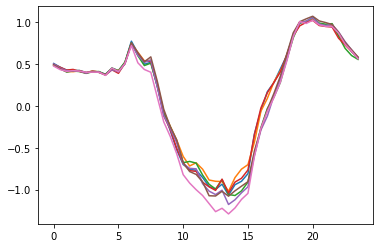

In [81]:
P_dm_cv = dm_cv(P_nl, 4)

plt.plot(P_dm.index, P_dm_cv.T, alpha=1);
P_dm_cv.shape

Ccl: removing 2 or 3 days is the maximum to get enough samples to compute a std on it.

#### WT coeff uncertainty


In [82]:
wavelet='db2'
mode = 'periodization'

P_dm_cv = dm_cv(P_nl, 2)
n_samp = P_dm_cv.shape[0]


coeffs_cv = []

for i in range(n_samp):
    coeffs_cv.append(pywt.wavedec(P_dm_cv[i], wavelet, mode=mode))
coeffs_cv = np.array(coeffs_cv)
coeffs_cv.shape

(14, 5)

In [83]:
coeffs_cv = pywt.wavedec(P_dm_cv, wavelet, mode=mode, axis=1)
coeffs_cv

[array([[ 2.90094651,  1.34954865, -2.48039351],
        [ 2.84751147,  1.39780103, -2.27485234],
        [ 2.84599242,  1.39444337, -2.37811024],
        [ 2.86444585,  1.41318061, -2.21464981],
        [ 2.81430935,  1.43778969, -2.54310728],
        [ 2.83086252,  1.37685145, -2.46202716],
        [ 2.83112614,  1.36129011, -2.3111896 ],
        [ 2.86269102,  1.36474026, -2.41271013],
        [ 2.85475642,  1.41709219, -2.42055603],
        [ 2.85390579,  1.38488702, -2.79360187],
        [ 2.85965052,  1.39611305, -2.42072511],
        [ 2.87973211,  1.45879261, -2.66251786],
        [ 2.80126728,  1.31531684, -2.74690142],
        [ 2.87708846,  1.25915605, -2.81586539]]),
 array([[-0.35754306, -1.55018945,  1.77386706],
        [-0.35746519, -1.44243813,  1.72617071],
        [-0.37061374, -1.48445006,  1.72797329],
        [-0.36802979, -1.35702642,  1.7060261 ],
        [-0.3532535 , -1.26621949,  1.78120432],
        [-0.33798748, -1.39387302,  1.72147293],
        [-0.351044

In [84]:
len(coeffs_cv)

5

In [85]:
coeffs_cv[4].shape

(14, 24)

## Gaussian Mixture

Here the goal is to fit directly a distribution at each hour of the day. This is more general than fitting just the mean and the standard deviation. Also, fitting a mixture model is one simple way to model the **bimodality** observed during the sun shining periods (cf. histograms above).

The GMM is interesting to:
* get smooth distributions
* regenerate thousands of samples

In the daily patter modeling, GMM can be applied in to ways:
* fit 48 GMMs of dimension 1, one for each hod
  * ☹ potential correlation between instants is dropped
  * ☺ the resulting 1D density is simple to manipulate (e.g. integrate into a cdf to get quantiles)
* fit 1 GMM of dimension 48
  * ☹ this forces the clustering to be the same during an entire day,
    so there is a strong notion of persistence in this model
  * this raises the question of correlation between instants
  * keeping in mind that we have only 30 samples, the model should be kept simple?
  * ccl: a *diagonal* covariance matrix makes most sense here
    * variance can be different in each dim (= each hod)
    * correlation between instants is dropped
  * a *full* cov is also possible, if it works
  * *tied* and *spherical* cov makes no sense here
* third alternative: fit one GMM of dim 48 to data which has been sorted at each hour of the day?


References:
* Jake VanderPlas' *Python Data Science Handbook*: [In Depth: Gaussian Mixture Models](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)
  * JVP explains that GMMs can be seen as density estimators rather than a clustering algorithm.
  * Thus GMMs can be used as generative models.
* Sckit-learn User Guide: [Unsupervised learning/Gaussian mixture models](https://scikit-learn.org/stable/modules/mixture.html)

In [86]:
from sklearn import mixture

### Fit one GMM of dimension 48

In [90]:
P_fold.shape

(30, 48)

In [172]:
gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag', random_state=0)
gmm.fit(P_fold)
gmm.bic(P_fold)

1289.850327502393

#### Clustered spagheti plot

cluster for each sample

In [173]:
c = gmm.predict(P_fold)
c

array([1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0,
       2, 1, 1, 1, 1, 1, 0, 0])

In [174]:
hod = np.arange(48)/2

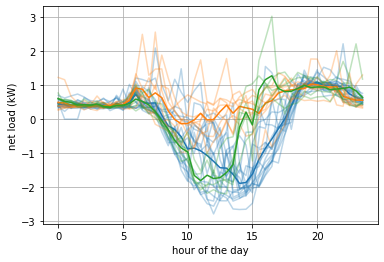

In [175]:
for i in range(gmm.n_components):
    plt.plot(hod, P_fold[c==i,:].T, c=f'C{i}', alpha=0.3)
    plt.plot(hod, gmm.means_[i,:], c=f'C{i}')
plt.xlabel('hour of the day')
plt.ylabel('net load (kW)')
plt.grid();

In [176]:
gmm.means_.shape

(3, 48)

In [177]:
gmm.covariances_.shape

(3, 48)

### Fit 48 different GMMs of dimension 1

In [283]:
P_fold_s = np.sort(P_fold, axis=0)
P_fold_cens = P_fold_s[2:-2,:]

Study the number of components:

In [290]:
n_comp_max = 4
gmm_list = [mixture.GaussianMixture(n_components=i+1, covariance_type='diag', n_init=2)
            for i in range(n_comp_max)]

bic = np.zeros((n_comp_max,48))

for h in range(48):
    X = P_fold[:,[h]]
    # add some smoothing with neighbor times
    X = np.vstack((X, P_fold[:,[(h-1)%48]]))
    X = np.vstack((X, P_fold[:,[(h+1)%48]]))
    
    for i in range(n_comp_max):
        gmm_list[i].fit(X)
        bic[i,h] = gmm_list[i].bic(X)

In [291]:
bic_cens = np.zeros((n_comp_max,48))

for h in range(48):
    X = P_fold_cens[:,[h]]
    # add some smoothing with neighbor times
    X = np.vstack((X, P_fold_cens[:,[(h-1)%48]]))
    X = np.vstack((X, P_fold_cens[:,[(h+1)%48]]))
    
    for i in range(n_comp_max):
        gmm_list[i].fit(X)
        bic_cens[i,h] = gmm_list[i].bic(X)

In [292]:
rbic      = bic - bic[[0],:]
rbic_cens = bic_cens - bic_cens[[0],:]

In [293]:
n_best = rbic.argmin(axis=0)+1
n_best

array([2, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,
       2, 3, 2, 3])

In [294]:
n_best_cens = rbic_cens.argmin(axis=0)+1
n_best_cens

array([1, 2, 1, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1])

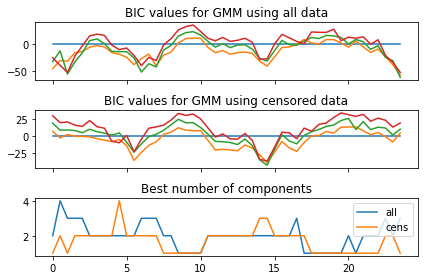

In [300]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True)
ax1.plot(hod, rbic.T)
ax1.set_title('BIC values for GMM using all data')

ax2.plot(hod, rbic_cens.T)
ax2.set_title('BIC values for GMM using censored data')

ax3.plot(hod, n_best, label='all')
ax3.plot(hod, n_best_cens, label='cens')
ax3.legend()
ax3.set_title('Best number of components');
fig.tight_layout()

Observation: 

* 2 clusters make most sense most of the time. From 8:00 to 10:00, one cluster is enough (also in the afternoon, but difference is small)
* open issue of outliers which yield clusters with only one point

In [234]:
gmm1 = mixture.GaussianMixture(n_components=1, covariance_type='diag', n_init=5)
gmm2 = mixture.GaussianMixture(n_components=2, covariance_type='diag', n_init=5)

gmm_means = np.zeros((2,48))
gmm_cov = np.zeros((2,48))

for h in range(48):
    X = P_fold[:,[h]]
    # add some smoothing with neighbor times
    X = np.vstack((X, P_fold[:,[(h-1)%48]]))
    X = np.vstack((X, P_fold[:,[(h+1)%48]]))
    # init means to get presorted clustered (works 95% of the time)
    #gmm.means_init = np.array([[X.min()],[X.max()]])
    gmm1.fit(X)
    gmm2.fit(X)
    if gmm1.bic(X) < gmm2.bic(X):
        gmm = gmm1
    else:
        gmm = gmm2
    means_h = gmm.means_[:,0]
    # sort the means:
    idx = means_h.argsort()
    gmm_means[:,h] = means_h[idx]
    gmm_cov[:,h] = gmm.covariances_[idx,0]
    #gmm_means[:,h] = means_h
    #gmm_cov[:,h] = gmm.covariances_[:,0]

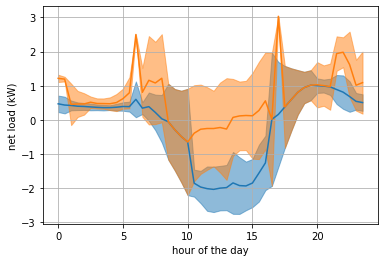

In [235]:
for i in range(gmm.n_components):
    m = gmm_means[i,:]
    s = np.sqrt(gmm_cov[i,:])
    plt.plot(hod, m , c=f'C{i}')
    plt.fill_between(hod, m-2*s, m+2*s, color=f'C{i}', alpha=0.5)
plt.xlabel('hour of the day')
plt.ylabel('net load (kW)')
plt.grid();

### Fit GMM on sorted data

In [260]:
P_fold_s = np.sort(P_fold, axis=0)

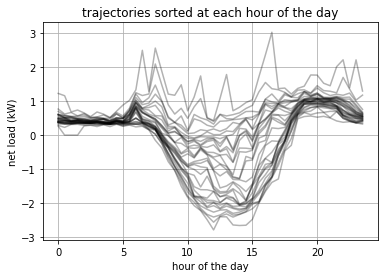

In [263]:
plt.plot(hod, P_fold_s.T, 'k-', alpha=0.3);
plt.xlabel('hour of the day')
plt.ylabel('net load (kW)')
plt.title('trajectories sorted at each hour of the day')
plt.grid();

In [280]:
X = P_fold_s[2:-2,:]
X.shape

(26, 48)

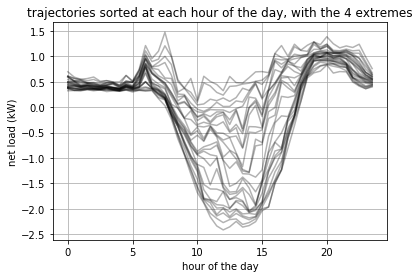

In [281]:
plt.plot(hod, X.T, 'k-', alpha=0.3);
plt.xlabel('hour of the day')
plt.ylabel('net load (kW)')
plt.title('trajectories sorted at each hour of the day, with the 4 extremes')
plt.grid();

In [272]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='diag', random_state=0)
gmm.fit(X)
gmm.bic(X)

-1135.0253867707206

In [274]:
c = gmm.predict(X)

Note: here BIC mininimization makes no more sense!

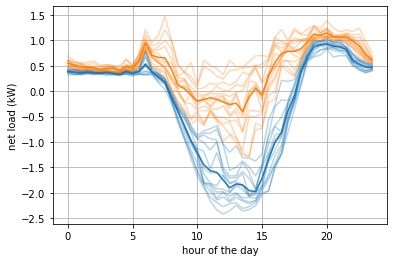

In [275]:
for i in range(gmm.n_components):
    plt.plot(hod, X[c==i,:].T, c=f'C{i}', alpha=0.3)
    plt.plot(hod, gmm.means_[i,:], c=f'C{i}')
plt.xlabel('hour of the day')
plt.ylabel('net load (kW)')
plt.grid();